# Training data

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
files = list(Path("/home/simonpf/data_3/ccic/training_data/").glob("**/cloudsat_match*.nc"))
data = xr.load_dataset(np.random.choice(files))

The retrieval output is stored in a sparse format. The variables ``profile_row_inds`` and ``profiles_col_inds`` specify the indices of the rows and columns of the 2D input image that the profiles correspond to.

In [4]:
row_inds = data.profile_row_inds
col_inds = data.profile_column_inds

In [5]:
iwp = data.iwp.data
iwp_rand = data.iwp_rand.data
iwc = data.iwc.data
cloud_class = data.cloud_class.data
tbs = data.ir_win.data[row_inds, col_inds]
cs_lats = data.latitude_cloudsat.data
cs_lons = data.longitude_cloudsat.data

In [6]:
data

<xarray.Dataset>
Dimensions:              (latitude: 256, longitude: 256, levels: 20,
                          profiles: 309)
Coordinates:
    time                 datetime64[ns] 2010-03-08T14:30:00.000026880
  * longitude            (longitude) float32 169.5 169.5 169.6 ... 178.7 178.8
  * latitude             (latitude) float32 39.46 39.42 39.39 ... 30.22 30.18
  * levels               (levels) float32 500.0 1.5e+03 ... 1.85e+04 1.95e+04
Dimensions without coordinates: profiles
Data variables:
    ir_win               (latitude, longitude) float32 252.0 248.0 ... 289.0
    iwc                  (profiles, levels) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    iwp                  (profiles) float32 223.0 174.0 250.3 ... 0.0 0.0 0.0
    iwp_rand             (profiles) float32 215.4 214.6 215.0 ... 0.0 0.0 0.0
    time_cloudsat        (profiles) datetime64[ns] 2010-03-08T14:31:25 ... 20...
    cloud_mask           (profiles) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    cloud_class          (profiles, levels) int8 0 0 0 0 2 2 2 ... 0 0 0 0 0 0 0
    latitude_cloudsat    (profiles) float32 39.45 39.47 39.42 ... 30.22 30.18
    longitude_cloudsat   (profiles) float32 175.6 175.6 175.5 ... 172.9 172.9
    profile_row_inds     (profiles) int16 0 0 1 2 3 3 ... 251 252 253 254 255
    profile_column_inds  (profiles) int16 166 167 166 166 165 ... 95 95 94 94 94
Attributes:
    input_source:  GPMIR

/tmp/ipykernel_1111559/2016684916.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m = ax.pcolormesh(x, y, iwc.T, norm=iwc_norm)
/tmp/ipykernel_1111559/2016684916.py:33: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m = ax.pcolormesh(x, y, cloud_class.T, cmap="Set2", norm=Normalize(-0.5, 7.5))


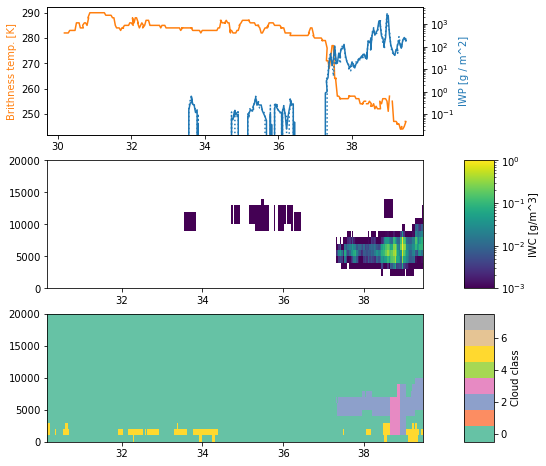

In [7]:
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm, Normalize

f = plt.figure(figsize=(8, 8))
gs = GridSpec(3, 2, width_ratios=(1.0, 0.08))

axs = np.array([f.add_subplot(gs[i, 0]) for i in range(3)])

# IWP and Tbs
x = cs_lats
ax = axs[0]
ax.plot(cs_lats, tbs, c="C1")
ax.set_ylabel("Brithness temp. [K]", color="C1")
ax = ax.twinx()
ax.plot(cs_lats, iwp, c="C0")
ax.plot(cs_lats, iwp_rand, c="C0", ls=":")
ax.set_yscale("log")
ax.set_ylabel("IWP [g / m^2]", color="C0")

# IWC
ax = axs[1]
iwc_norm = LogNorm(1e-3, 1e0)
y = data.levels.data
m = ax.pcolormesh(x, y, iwc.T, norm=iwc_norm)

cax = f.add_subplot(gs[1, -1])
plt.colorbar(m, cax=cax, label="IWC [g/m^3]")


# Cloud mask
ax = axs[2]
y = data.levels.data
m = ax.pcolormesh(x, y, cloud_class.T, cmap="Set2", norm=Normalize(-0.5, 7.5))

cax = f.add_subplot(gs[2, -1])
plt.colorbar(m, cax=cax, label="Cloud class")

In [17]:
data.cloud_class > 0

<xarray.DataArray 'cloud_class' (profiles: 309, levels: 20)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])
Coordinates:
    time     datetime64[ns] 2010-03-08T14:30:00.000026880
  * levels   (levels) float32 500.0 1.5e+03 2.5e+03 ... 1.85e+04 1.95e+04
Dimensions without coordinates: profiles

In [47]:
from ccic.data.training_data import CCICDataset
training_data = CCICDataset("/home/simonpf/data_3/ccic/training_data/")

In [48]:
from torch.utils.data import DataLoader
loader = DataLoader(training_data, batch_size=2)

In [49]:
x, y = next(iter(loader))

In [23]:
x[0].shape

torch.Size([2, 3, 256, 256])

In [52]:
y["cloud_mask"].dtype

torch.int8

In [55]:
y["cloud_mask"].max()

tensor(1, dtype=torch.int8)

In [60]:
(64 * 20 * 256 * 256 * 2) / 1e6

167.77216

In [33]:
from ccic.models import CCICModel

In [35]:
model = CCICModel(2, 32, 128)

In [37]:
128 * 20


2560

In [36]:
model

CCICModel(
  (stem): Sequential(
    (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
    (1): CNBlock(
      (block): Sequential(
        (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=32)
        (1): Permute()
        (2): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
        (3): Linear(in_features=32, out_features=128, bias=True)
        (4): GELU(approximate=none)
        (5): Linear(in_features=128, out_features=32, bias=True)
        (6): Permute()
      )
      (stochastic_depth): StochasticDepth(p=0.0, mode=row)
    )
  )
  (encoder): SpatialEncoder(
    (downsamplers): ModuleList(
      (0): None
      (1): None
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): Sequential(
          (0): Sequential(
            (0): Permute()
            (1): LayerNorm((32,), eps=1e-06, elementwise_affine=True)
            (2): Permute()
          )
          (1): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
          (2): CNB

In [39]:
y["cloud_class"].shape

torch.Size([2, 20, 256, 256])

In [41]:
x, y = training_data[0]

In [46]:
y["iwc"].dtype

torch.float32

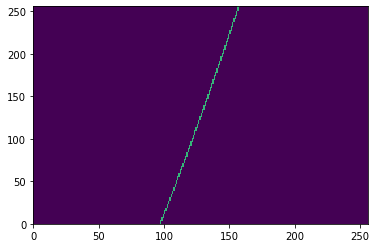

In [15]:
plt.pcolormesh(y["cloud_mask"], vmin=-1, vmax=2)

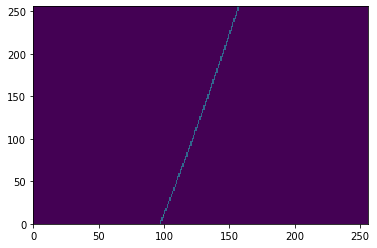

In [16]:
plt.pcolormesh(y["cloud_class"][10], vmin=-1, vmax=2)

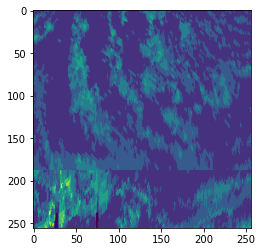

In [28]:
plt.imshow(x[0])

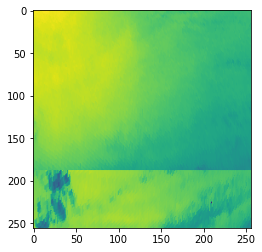

In [23]:
plt.imshow(x[1])

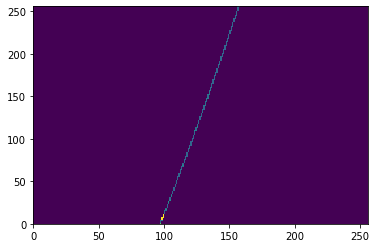

In [19]:

plt.pcolormesh(y["iwp"], vmin=-1, vmax=2)